# MNIST 데이터셋 가져오기
+ 실습에 사용할 MNIST datasets을 torchvision을 통해서 다운로드할 수 있다.

In [1]:
# transforms와 datasets.MNIST를 불러온다.
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision import utils

In [2]:
# mnist 데이터셋의 tranformer를 만들어준다.
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, ), (1.0, ))
])

In [3]:
download_root = r"D:\NoShare\MNIST_DATASET"

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

# 데이터 살펴보기

+ image 정보, label 값 보기
+ pyplot으로 이미지 출력하기

In [4]:
# 이미지에 대한 정보 및 라벨 값 보기
image, label = train_dataset[0]

print("image")
# 28 X 28 사이즈의 흑백 이비지 (1에 가까울 수록 흰색)
print(f"shape\t:\t {image.shape}") 
# 28개의 숫자 출력
print(f"7th row\t:\t {image[0][6]}")  

# 라벨은 5
print(f"label\t:\t{label}")

image
shape	:	 torch.Size([1, 28, 28])
7th row	:	 tensor([-0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
        -0.3824, -0.3588, -0.1314,  0.1039,  0.1667,  0.4922,  0.4922,  0.4922,
         0.4922,  0.4922,  0.3824,  0.1745,  0.4922,  0.4490,  0.2647, -0.2490,
        -0.5000, -0.5000, -0.5000, -0.5000])
label	:	5


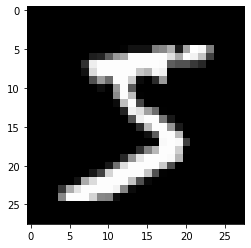

In [5]:
from matplotlib import pyplot as plt

# 이미지 시각화하기
import numpy as np 
def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

# grid로 데이터 시각화하기
def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
imshow(image)

# DataLoader로 미니배치 구성

In [6]:
# DataLoader를 이용해서 batch size에 맞게 데이터들을 가져올 수 있다.
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# MLP 모델 만들어서 학습해보기

+ GPU 사용 여부 체크
+ nn.Module을 이용해서 모델 클래스 생성

In [7]:
import torch 

# GPU 사용 여부를 체크
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

print(DEVICE)

cuda


In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# MLP 모델 클래스 생성
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(28 * 28, 128)
        self.hidden_layer = nn.Linear(128, 128)
        # MNIST 의 클래스가 총 10개이므로 10개로 Output을 만듬
        self.output_layer = nn.Linear(128, 10)
    
    def forward(self, x):
        # Image를 1차원 벡터로 쭉 핀다.
        x = x.view(-1, 28 * 28)
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        x = F.log_softmax(x, dim=1)
        return x

# 학습률
learning_rate = 0.001

# model을 DEVICE에서 연산하겠다.
model = MLP().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# model의 형태를 보여줌
print(model)

MLP(
  (input_layer): Linear(in_features=784, out_features=128, bias=True)
  (hidden_layer): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
def train(epoch, model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                    
def evaluate(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            valid_loss += F.cross_entropy(output, target, reduction = "sum").item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_accuracy = 100. * correct / len(valid_loader.dataset)
    return valid_loss, valid_accuracy

In [10]:
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(epoch, model, train_loader, optimizer)
    valid_loss, valid_accuracy = evaluate(model, valid_loader)
    print(f"[EPOCH: {epoch}], \tValidation Loss: {valid_loss:.4f}, \tValidation Accuracy: {valid_accuracy:.2f} %testset_prediction\n")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.288515
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.548401
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.442782
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.158295
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.165676
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.260104
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.400670
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.265993
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.304941
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.185420
[EPOCH: 1], 	Validation Loss: 0.2272, 	Validation Accuracy: 93.23 %testset_prediction

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.373630
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.359457
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.230219
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.222545
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.121303
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.232163
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.218077
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.250364
Train Epoch: 2 [51200/600

# 학습한 모델의 예측결과 확인하기

+ 배치에 포함된 사진들 확인하기
+ 실제 예측한 결과 확인하기

In [11]:
def testset_prediction(model, test_loader):
    model.eval()
    result = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            prediction = output.max(1, keepdim = True)[1]
            result.append(prediction)
    return result

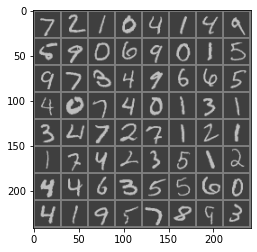

In [12]:
test_images, test_labels   = next(iter(test_loader))
imshow_grid(test_images)

In [14]:
predict_results = testset_prediction(model, test_loader)
print("shape\t:\t", predict_results[0].shape)

print("prediction\t:\t", predict_results[0].tolist())
print("real_label\t:\t", test_labels.view(1, -1))

shape	:	 torch.Size([64, 1])
prediction	:	 [[7], [2], [1], [0], [4], [1], [4], [9], [6], [9], [0], [6], [9], [0], [1], [5], [9], [7], [3], [4], [9], [6], [6], [5], [4], [0], [7], [4], [0], [1], [3], [1], [3], [4], [7], [2], [7], [1], [2], [1], [1], [7], [4], [2], [3], [5], [1], [2], [4], [4], [6], [3], [5], [5], [6], [0], [4], [1], [9], [5], [7], [8], [9], [3]]
real_label	:	 tensor([[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
         4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
         4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3]])
